# Imports

In [1]:
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from typing import Optional, Tuple, Union
import matplotlib.pyplot as plt
from syntheval import SynthEval

# User Settings

In [2]:
@dataclass
class Config:
    data_dir: Path = Path("../../data")
    figures_dir: Path = Path("figures")
    results_dir: Path = Path("results")

    real_file: str = "20250301_data_20250510_122405_final_100_train.csv"
    synth_file: str = "20250301_data_20250510_122405_final_100_synth.csv"
    holdout_file: str = "20250301_data_20250510_122405_final_100_holdout.csv"

    random_seed: int = 42
    sensitive_cols = ["icu_admission_24h", "icd_block"]

    save_data: bool = True

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)


# Utility Functions

In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        # df[col] = df[col].astype('category')
        df[col] = df[col].astype('object') # 'category' führt zu Problemen mit dem OneHotEncoder

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')
        # df[col] = df[col].astype('int32')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = None,
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

# Main Routine
## Data Import

In [4]:
cfg = Config()
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df_train, df_synth, df_holdout = load_data(
    cfg.real_file,
    cfg.synth_file,
    cfg.holdout_file,
    data_dir=cfg.data_dir
)

df_holdout = df_holdout.dropna().reset_index(drop=True)

In [5]:
num_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'night_arrival', 'weekend_arrival', 'icu_admission_24h', 'icd_block']
ord_cols = ['consciousness_level','news_score']

cat_ord_cols = cat_cols + ord_cols
print(cat_ord_cols)

['gender', 'ethnicity', 'chief_complaint', 'night_arrival', 'weekend_arrival', 'icu_admission_24h', 'icd_block', 'consciousness_level', 'news_score']


## Vor-Test / Debugging

Die Funktion berechnet für jedes angegebene sensitive Attribut die Metriken Accuracy, Precision, usw. und gibt letztlich, bei Angabe mehrerer sensitiver Attribute, den Mittelwert und den SE aus.
In der einfachen Ausgabe wird nur die Accuracy ausgegeben. Auf die anderen Metriken lässt sich via _raw_results zugreifen.


Folgender Code erzeugt
RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Wenn man nur mit einem sensitiven Attribut prüft → Wurden ignoriert.

In [6]:
# df_synth = df_synth.sample(n=1000, random_state=cfg.random_seed).reset_index(drop=True)
# df_holdout = df_holdout.sample(n=1000, random_state=cfg.random_seed).reset_index(drop=True)

# sens = ['icu_admission_24h']
# cat_ord_cols.remove('icu_admission_24h')
# cat_ord_cols.remove('icd_block')
# df_holdout.drop(columns='icd_block', inplace=True)
# df_synth.drop(columns='icd_block', inplace=True)

In [7]:
# aia = SynthEval(real_dataframe=df_holdout, cat_cols=cat_ord_cols, verbose=False)
# aia_res = aia.evaluate(df_synth, att_discl={'sensitive': sens})
# aia_raw = aia._raw_results['att_discl'].copy()


In [8]:
# # print(aia_res)
# # print(aia_res['val'][0])

# # print(aia_raw)
# test = pd.DataFrame.from_dict(aia_raw, orient='index', columns=['value']).reset_index().rename(columns={'index': 'metric'})
# print(test)


## Functions
### Calculation

In [9]:
def run_attribute_disclosure(
    real_df: pd.DataFrame,
    synth_df: pd.DataFrame,
    cat_cols: list[str],
    sensitive_cols: list[str],
    verbose: bool = False
) -> pd.DataFrame:
    """
    Führt für jedes sensitive Feature eine Attribute Disclosure Analyse durch.
    
    Args:
        real_df: DataFrame, das als Testdaten dient (z.B. Holdout oder Train).
        synth_df: DataFrame, auf dem das Angriffsmodell trainiert wird (synthetische Daten).
        cat_cols: Liste aller kategorialen Spalten (inkl. aller sensitiven Features).
        sensitive_cols: Liste der sensitiven Feature-Namen.
        verbose: Ob SynthEval verbose laufen soll.
    
    Returns:
        DataFrame mit den Disclosure-Metriken für jedes sensitive Feature.
    """
    results_list = []

    for sens in sensitive_cols:
        # 1. aktuelles sensitive fokussieren
        current_sensitive = [sens]

        # 2. cat_cols ohne die anderen sens. Features
        cat_cols_iter = [c for c in cat_cols if c in cat_cols and c not in [s for s in sensitive_cols if s != sens]]

        # 3. droppe die anderen sensitiven Features aus den DataFrames
        others = [s for s in sensitive_cols if s != sens]
        real_iter = real_df.drop(columns=others, errors='ignore')
        synth_iter = synth_df.drop(columns=others, errors='ignore')

        # 4. SynthEval initialisieren
        aia = SynthEval(
            real_dataframe=real_iter,
            cat_cols=cat_cols_iter,
            verbose=verbose
        )

        # 5. ausführen
        aia.evaluate(
            synthetic_dataframe=synth_iter,
            att_discl={'sensitive': current_sensitive}
        )

        # 6. rohdaten holen und in DataFrame transformieren
        aia_raw = aia._raw_results['att_discl'].copy()
        df_res = (
            pd.DataFrame
            .from_dict(aia_raw, orient='index', columns=['value'])
            .reset_index()
            .rename(columns={'index': 'metric'})
        )
        df_res['sensitive_feature'] = sens

        results_list.append(df_res)

    # 7. zusammenführen
    final_results = pd.concat(results_list, ignore_index=True)
    return final_results


### Plotting Function

In [55]:
def plot_attribute_disclosure(final_results: pd.DataFrame, fname_suffix: str):
    """
    Plots radar charts of Attribute Disclosure metrics for each sensitive feature.

    Args:
        final_results: DataFrame with columns ['metric', 'value', 'sensitive_feature'].
    """
    metrics = [
        'Attr Dis accuracy',
        'Attr Dis precision',
        'Attr Dis recall',
        'Attr Dis macro F1',
    ]
    metrics_short = ['Acc', 'Prec', 'Rec', 'M-F1']

    # Winkel für das Radar Chart berechnen
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Kreis schließen

    # Einzigartige sensitive Features
    unique_features = final_results['sensitive_feature'].unique()
    fig, axes = plt.subplots(
        1,
        len(unique_features),
        subplot_kw=dict(polar=True),
        figsize=(1.9 * len(unique_features), 1.9)
    )

    # Sicherstellen, dass axes iterierbar ist
    if len(unique_features) == 1:
        axes = [axes]

    # Für jedes Feature einen Radar-Plot zeichnen
    for ax, feature in zip(axes, unique_features):
        df_attr = final_results[
            (final_results['sensitive_feature'] == feature) &
            (final_results['metric'].isin(metrics))
        ]
        values = df_attr['value'].tolist()
        values += values[:1]

        ax.plot(angles, values, marker='o')
        ax.fill(angles, values, alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_rmin(0)
        ax.set_rmax(1)
        ax.set_rticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_yticklabels(['0', '', '0.5', '', '1'])
        ax.set_xticklabels(metrics_short)
        ax.xaxis.set_tick_params(pad=-3)
        ax.set_title(feature, y=1.2)

    plt.tight_layout()
    if cfg.save_data:
        fname = f'AIA_{fname_suffix}_{current_timestamp}.tiff'
        fullpath = cfg.figures_dir / fname
        plt.savefig(
            fullpath,
            dpi=300,
            format='tiff',
            bbox_inches='tight',
            pil_kwargs={'compression': 'tiff_lzw'}
        )
        print(f"Abbildung gespeichert unter: {fullpath}")
    plt.show()


## Synth → Holdout

### Code

In [ ]:
df_sh = run_attribute_disclosure(
    real_df=df_holdout,
    synth_df=df_synth,
    cat_cols=cat_ord_cols,
    sensitive_cols=cfg.sensitive_cols,
    verbose=False
)

if cfg.save_data:
    fname = f'AIA_Holdout_Synth_{current_timestamp}.csv'
    fullpath = cfg.results_dir / fname
    df_sh.to_csv(fullpath, index=False, sep=';', encoding='utf-8', decimal=',')
    print(f"Ergebnisse gespeichert unter: {fullpath}")

c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Ergebnisse gespeichert unter: results\AIA_Train_Synth_20250515_174654.csv


c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### load instead

In [7]:
df_sh = pd.read_csv(
    cfg.results_dir / f'AIA_Holdout_Synth_20250515_174654.csv',
    sep=';',
    encoding='utf-8',
    decimal=','
)

### Visualisierung

Abbildung gespeichert unter: figures\AIA_synth_holdout_20250601_162135.tiff


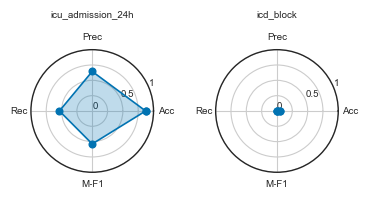

In [56]:
plot_attribute_disclosure(df_sh, fname_suffix='synth_holdout')

## Synthetic → Train
### Berechnung

In [13]:
df_st = run_attribute_disclosure(
    real_df=df_train,
    synth_df=df_synth,
    cat_cols=cat_ord_cols,
    sensitive_cols=cfg.sensitive_cols,
    verbose=False
)

if cfg.save_data:
    fname = f'AIA_Synth-Train_{current_timestamp}.csv'
    fullpath = cfg.results_dir / fname
    df_st.to_csv(fullpath, index=False, sep=';', encoding='utf-8', decimal=',')
    print(f"Ergebnisse gespeichert unter: {fullpath}")

c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Ergebnisse gespeichert unter: results\AIA_Synth-Train_20250515_174654.csv


c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [47]:
df_st = pd.read_csv(
    cfg.results_dir / f'AIA_Synth-Train_20250515_174654.csv',
    sep=';',
    encoding='utf-8',
    decimal=','
)

### Visualisierung

Abbildung gespeichert unter: figures\AIA_synth_train_20250601_162135.tiff


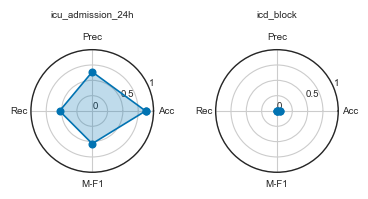

In [57]:
plot_attribute_disclosure(df_st, fname_suffix='synth_train')

## Train → Holdout
### Berechnung

In [15]:
df_th = run_attribute_disclosure(
    real_df=df_holdout,
    synth_df=df_train,
    cat_cols=cat_ord_cols,
    sensitive_cols=cfg.sensitive_cols,
    verbose=False
)

if cfg.save_data:
    fname = f'AIA_Train_Holdout_{current_timestamp}.csv'
    fullpath = cfg.results_dir / fname
    df_th.to_csv(fullpath, index=False, sep=';', encoding='utf-8', decimal=',')
    print(f"Ergebnisse gespeichert unter: {fullpath}")

c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Ergebnisse gespeichert unter: results\AIA_Train_Holdout_20250515_174654.csv


c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Masterarbeit\venvs\syntheval\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [49]:
df_th = pd.read_csv(
    cfg.results_dir / f'AIA_Train_Holdout_20250515_174654.csv',
    sep=';',
    encoding='utf-8',
    decimal=','
)

### Visualisierung

Abbildung gespeichert unter: figures\AIA_train_holdout_20250601_162135.tiff


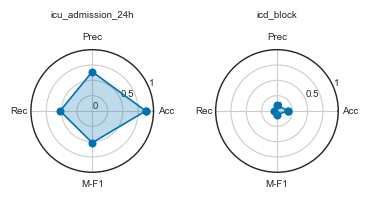

In [58]:
plot_attribute_disclosure(df_th, fname_suffix='train_holdout')

# Interpretation
✅ Accuracy
→ Anteil der korrekt vorhergesagten Werte (egal ob Kategorie A oder B) an allen Vorhersagen.
- 0.0: Angreifer liegt immer falsch → kein Risiko (sehr unwahrscheinlich).
- 0.5: Angreifer rät wie Zufall → kein Privacy-Leakage.
- 0.5 bis 1.0: Angreifer zunehmend besser als Zufall → steigendes Risiko.
- 1.0: Angreifer immer korrekt → maximales Privacy-Risiko.


✅ Precision (Präzision)
→ Anteil der korrekt vorhergesagten positiven Klassen (z.B. „weiblich“) an allen vorhergesagten positiven Klassen.
- 0.0: Alle vorhergesagten Attribute sind falsch → kein Risiko. (viele falsche positive → Angreifer oft daneben.)
- 0.5: Hälfte der Vorhersagen korrekt → wie Zufall → kein signifikanter Leak.
- 1.0: Alle vorhergesagten Attribute korrekt → sehr hohes Risiko. (Angreifer macht wenig falsche „Treffer“, ist „vorsichtig“.)


✅ Recall (Sensitivität)
→ Anteil der tatsächlichen positiven Klassen, die korrekt erkannt wurden.
- 0.0: Kein einziges sensibles Attribut erkannt → sehr guter Privacy-Schutz. (Angreifer „übersieht“ viele → besserer Privacy-Schutz.)
- 0.5: Hälfte der tatsächlichen Attribute erkannt → mittleres Risiko.
- 1.0: alle Attribute korrekt erkannt → maximales Risiko. (Angreifer erkennt viele wahre Attribute.)


✅ Macro-F1
→ harmonischer Mittelwert aus Precision und Recall, gleichgewichtet über alle Klassen.
- 0.0: Precision & Recall katastrophal → kein Leak.
- 0.5: Angreifer wie Zufall → kein signifikanter Leak.
- 1.0: Angreifer perfekt in Balance zwischen Precision & Recall → sehr hohes Risiko. (Angreifer hat echte Vorhersagekraft → Privacy-Risiko.)


👉 Zusammenhang:
Alle vier Metriken zeigen auf unterschiedliche Weise, wie erfolgreich ein Angreifer sensible Attribute aus synthetischen Daten vorhersagen kann.
→ Je höher die Werte, desto größer das Privacy-Risiko. Je näher an 0.5 oder darunter, desto schlechter der Angreifer → geringeres Risiko.

→ Besonders auf Macro-F1 achten: guter Gesamteindruck von Angriffsleistung.

